
# Semana 9 — Funções de Ativação & Otimizadores (PyTorch) ⚙️🧠

Neste notebook você vai:
1) Comparar **funções de ativação** (ReLU, Tanh, LeakyReLU) em um MLP.  
2) Comparar **otimizadores** (Adam vs SGD+Momentum).  
3) Visualizar **curvas de loss** e **fronteiras de decisão** em `make_moons`.  

> Requisitos: `torch`, `scikit-learn`, `matplotlib`.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## 1) Dados — `make_moons` + padronização

In [2]:

X, y = make_moons(n_samples=2000, noise=0.25, random_state=SEED)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=SEED, stratify=y)

scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_te_s = scaler.transform(X_te)

Xtr_t = torch.tensor(X_tr_s, dtype=torch.float32)
ytr_t = torch.tensor(y_tr,   dtype=torch.long)
Xte_t = torch.tensor(X_te_s, dtype=torch.float32)
yte_t = torch.tensor(y_te,   dtype=torch.long)

train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=64, shuffle=True)
test_loader  = DataLoader(TensorDataset(Xte_t, yte_t),  batch_size=256, shuffle=False)

X_tr_s.shape, X_te_s.shape


((1500, 2), (500, 2))

## 2) Helpers — modelo, treino, avaliação e plot da fronteira

In [3]:

class MLP(nn.Module):
    def __init__(self, in_dim=2, hidden=(32,16), out_dim=2, activation="relu"):
        super().__init__()
        h1, h2 = hidden
        self.fc1 = nn.Linear(in_dim, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, out_dim)
        act = activation.lower()
        if act == "relu":
            self.act = nn.ReLU()
        elif act == "tanh":
            self.act = nn.Tanh()
        elif act in ("leakyrelu", "leaky_relu", "lrelu"):
            self.act = nn.LeakyReLU(0.01)
        else:
            raise ValueError("Ativação não suportada: "+activation)
        self.activation_name = act

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)
        return x

def train_model(model, train_loader, test_loader, epochs=200, optimizer_name="adam", lr=1e-3, momentum=0.9, weight_decay=0.0, use_scheduler=False):
    model = model.to(device)
    crit = nn.CrossEntropyLoss()
    if optimizer_name.lower() == "adam":
        opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name.lower() in ("sgd", "sgd_momentum", "sgdm"):
        opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    else:
        raise ValueError("Otimizador não suportado: "+optimizer_name)

    if use_scheduler:
        sched = torch.optim.lr_scheduler.StepLR(opt, step_size=50, gamma=0.5)
    else:
        sched = None

    tr_losses, va_losses = [], []
    for ep in range(1, epochs+1):
        model.train()
        run = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            opt.step()
            run += loss.item() * xb.size(0)
        tr_loss = run / len(train_loader.dataset)

        model.eval(); vrun = 0.0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                vrun += crit(model(xb), yb).item() * xb.size(0)
        va_loss = vrun / len(test_loader.dataset)

        tr_losses.append(tr_loss); va_losses.append(va_loss)
        if sched is not None:
            sched.step()

        if ep % 25 == 0 or ep == 1:
            print(f"epoch {ep:03d} | train={tr_loss:.4f} | val={va_loss:.4f}")
    return model, tr_losses, va_losses

def accuracy(model, loader):
    model.eval(); correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    return correct / total

def plot_boundary(model, X, y, title=""):
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
    with torch.no_grad():
        Z = model(torch.tensor(grid, device=device)).argmax(1).view(xx.shape).cpu().numpy()
    plt.figure(figsize=(6.4,5))
    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.scatter(X[:,0], X[:,1], c=y, s=18)
    plt.title(title); plt.xlabel("x1 (std)"); plt.ylabel("x2 (std)")
    plt.tight_layout(); plt.show()


## 3) Parte A — Comparando **funções de ativação** (Adam fixo)

In [4]:

epochs = 200
results_act = []

for act in ["relu", "tanh", "leakyrelu"]:
    print("\n=== Ativação:", act, "===")
    model = MLP(activation=act)
    model, tr, va = train_model(model, train_loader, test_loader, epochs=epochs, optimizer_name="adam", lr=1e-3, weight_decay=1e-4, use_scheduler=False)
    acc_tr = accuracy(model, train_loader)
    acc_te = accuracy(model, test_loader)
    results_act.append((act, acc_tr, acc_te, tr, va))

pd.DataFrame([(a,b,c) for a,b,c,_,_ in results_act], columns=["activation","acc_treino","acc_teste"]).sort_values("acc_teste", ascending=False)



=== Ativação: relu ===
epoch 001 | train=0.6181 | val=0.5456
epoch 025 | train=0.1452 | val=0.1595
epoch 050 | train=0.1349 | val=0.1586
epoch 075 | train=0.1333 | val=0.1608
epoch 100 | train=0.1306 | val=0.1593
epoch 125 | train=0.1320 | val=0.1604
epoch 150 | train=0.1293 | val=0.1603
epoch 175 | train=0.1308 | val=0.1601
epoch 200 | train=0.1289 | val=0.1601

=== Ativação: tanh ===
epoch 001 | train=0.5723 | val=0.4752
epoch 025 | train=0.2300 | val=0.2183
epoch 050 | train=0.1439 | val=0.1537
epoch 075 | train=0.1363 | val=0.1519
epoch 100 | train=0.1362 | val=0.1526
epoch 125 | train=0.1367 | val=0.1534
epoch 150 | train=0.1360 | val=0.1530
epoch 175 | train=0.1347 | val=0.1536
epoch 200 | train=0.1349 | val=0.1532

=== Ativação: leakyrelu ===
epoch 001 | train=0.6662 | val=0.5878
epoch 025 | train=0.1461 | val=0.1595
epoch 050 | train=0.1333 | val=0.1561
epoch 075 | train=0.1320 | val=0.1574
epoch 100 | train=0.1316 | val=0.1578
epoch 125 | train=0.1310 | val=0.1576
epoch 150 |

,activation,acc_treino,acc_teste
2,leakyrelu,0.953333,0.936
1,tanh,0.950000,0.934
0,relu,0.954000,0.932


### Curvas de loss por ativação

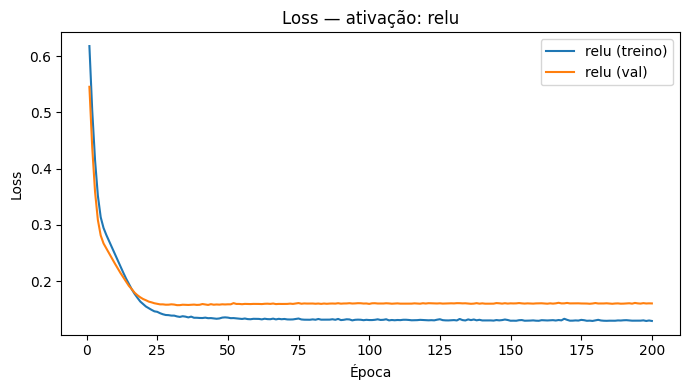

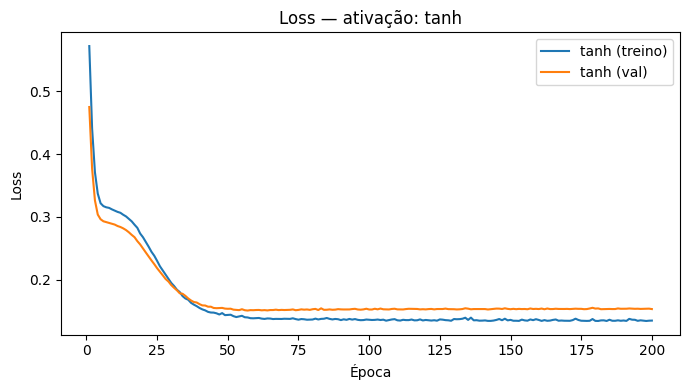

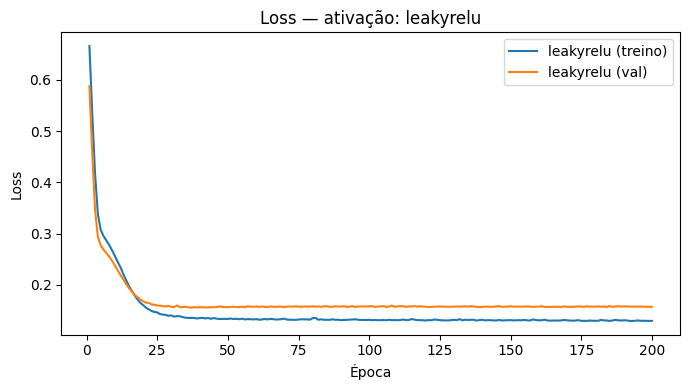

In [5]:

for act, acc_tr, acc_te, tr, va in results_act:
    plt.figure(figsize=(7,4))
    plt.plot(range(1,len(tr)+1), tr, label=f"{act} (treino)")
    plt.plot(range(1,len(va)+1), va, label=f"{act} (val)")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Loss — ativação: {act}")
    plt.legend(); plt.tight_layout(); plt.show()


### Fronteiras de decisão por ativação

epoch 001 | train=0.6474 | val=0.5977
epoch 025 | train=0.1527 | val=0.1634
epoch 050 | train=0.1334 | val=0.1581
epoch 075 | train=0.1313 | val=0.1579
epoch 100 | train=0.1309 | val=0.1588
epoch 125 | train=0.1310 | val=0.1585
epoch 150 | train=0.1300 | val=0.1598
epoch 175 | train=0.1305 | val=0.1591
epoch 200 | train=0.1301 | val=0.1604


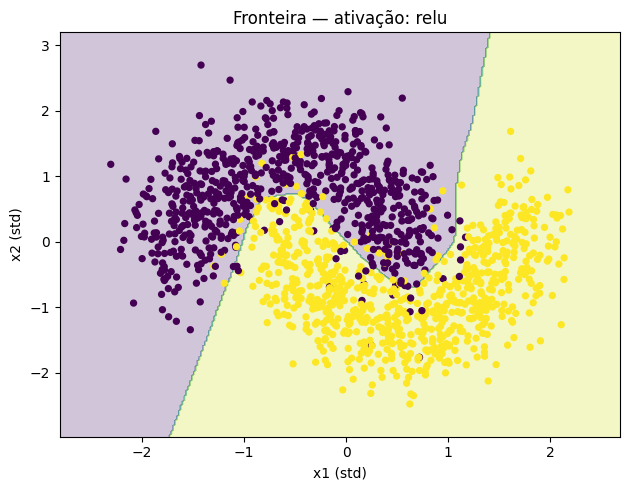

epoch 001 | train=0.6336 | val=0.5288
epoch 025 | train=0.2390 | val=0.2261
epoch 050 | train=0.1466 | val=0.1596
epoch 075 | train=0.1389 | val=0.1530
epoch 100 | train=0.1394 | val=0.1546
epoch 125 | train=0.1382 | val=0.1528
epoch 150 | train=0.1389 | val=0.1545
epoch 175 | train=0.1360 | val=0.1534
epoch 200 | train=0.1358 | val=0.1535


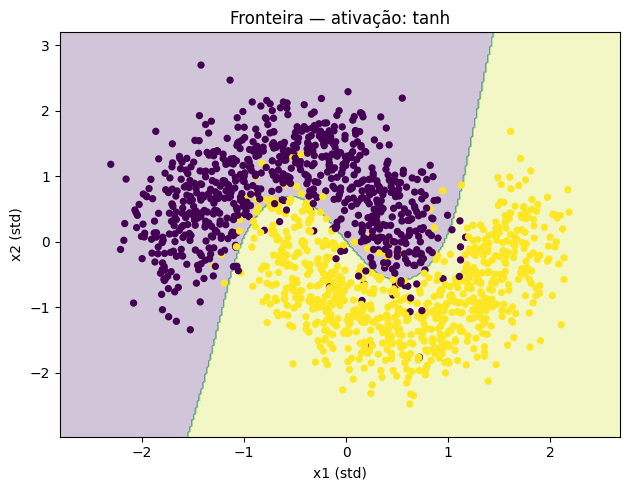

epoch 001 | train=0.6026 | val=0.5295
epoch 025 | train=0.1498 | val=0.1616
epoch 050 | train=0.1340 | val=0.1567
epoch 075 | train=0.1336 | val=0.1575
epoch 100 | train=0.1304 | val=0.1583
epoch 125 | train=0.1298 | val=0.1585
epoch 150 | train=0.1297 | val=0.1589
epoch 175 | train=0.1297 | val=0.1598
epoch 200 | train=0.1294 | val=0.1597


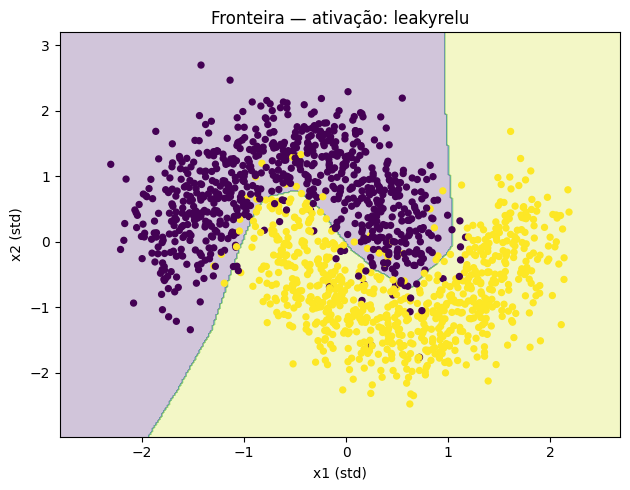

In [6]:

for act, acc_tr, acc_te, tr, va in results_act:
    model = MLP(activation=act)
    model, _, _ = train_model(model, train_loader, test_loader, epochs=epochs, optimizer_name="adam", lr=1e-3, weight_decay=1e-4, use_scheduler=False)
    plot_boundary(model, X_tr_s, y_tr, title=f"Fronteira — ativação: {act}")


## 4) Parte B — Comparando **otimizadores** (fixando ReLU)

In [7]:

epochs = 200
results_opt = []

print("\n=== Otimizador: Adam ===")
adam = MLP(activation="relu")
adam, tr_a, va_a = train_model(adam, train_loader, test_loader, epochs=epochs, optimizer_name="adam", lr=1e-3, weight_decay=1e-4, use_scheduler=True)
acc_tr_a = accuracy(adam, train_loader); acc_te_a = accuracy(adam, test_loader)
results_opt.append(("adam", acc_tr_a, acc_te_a, tr_a, va_a))

print("\n=== Otimizador: SGD (momentum=0.9) ===")
sgd = MLP(activation="relu")
sgd, tr_s, va_s = train_model(sgd, train_loader, test_loader, epochs=epochs, optimizer_name="sgd", lr=1e-2, momentum=0.9, weight_decay=1e-4, use_scheduler=True)
acc_tr_s = accuracy(sgd, train_loader); acc_te_s = accuracy(sgd, test_loader)
results_opt.append(("sgd_momentum", acc_tr_s, acc_te_s, tr_s, va_s))

pd.DataFrame([(n,a,b) for n,a,b,_,_ in results_opt], columns=["optimizer","acc_treino","acc_teste"]).sort_values("acc_teste", ascending=False)



=== Otimizador: Adam ===
epoch 001 | train=0.6821 | val=0.6129
epoch 025 | train=0.1452 | val=0.1589
epoch 050 | train=0.1343 | val=0.1568
epoch 075 | train=0.1331 | val=0.1569
epoch 100 | train=0.1320 | val=0.1575
epoch 125 | train=0.1315 | val=0.1574
epoch 150 | train=0.1312 | val=0.1573
epoch 175 | train=0.1309 | val=0.1574
epoch 200 | train=0.1309 | val=0.1574

=== Otimizador: SGD (momentum=0.9) ===
epoch 001 | train=0.6171 | val=0.4983
epoch 025 | train=0.1482 | val=0.1592
epoch 050 | train=0.1355 | val=0.1603
epoch 075 | train=0.1351 | val=0.1582
epoch 100 | train=0.1326 | val=0.1569
epoch 125 | train=0.1306 | val=0.1570
epoch 150 | train=0.1312 | val=0.1574
epoch 175 | train=0.1300 | val=0.1573
epoch 200 | train=0.1298 | val=0.1573


,optimizer,acc_treino,acc_teste
1,sgd_momentum,0.952,0.934
0,adam,0.954,0.930


### Curvas de loss por otimizador

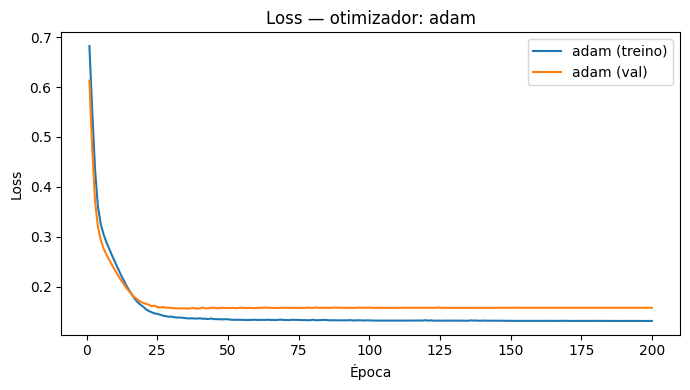

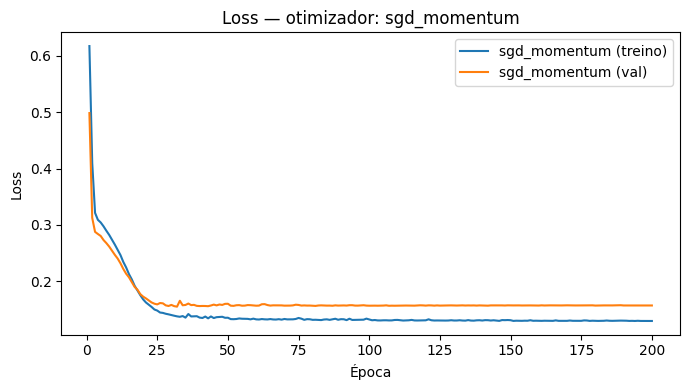

In [8]:

for name, acc_tr, acc_te, tr, va in results_opt:
    plt.figure(figsize=(7,4))
    plt.plot(range(1,len(tr)+1), tr, label=f"{name} (treino)")
    plt.plot(range(1,len(va)+1), va, label=f"{name} (val)")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Loss — otimizador: {name}")
    plt.legend(); plt.tight_layout(); plt.show()


### Fronteiras de decisão por otimizador

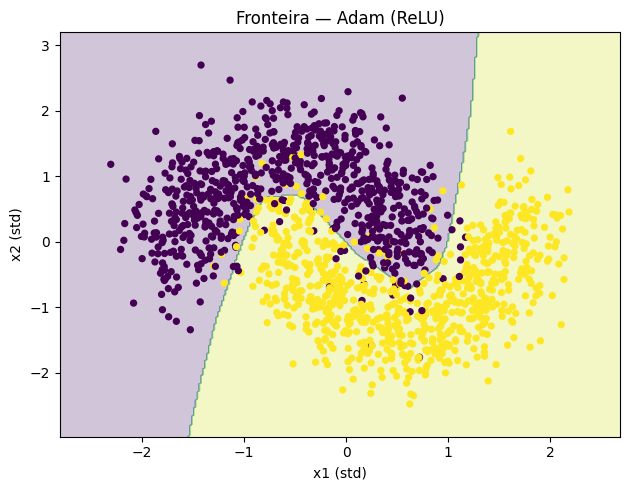

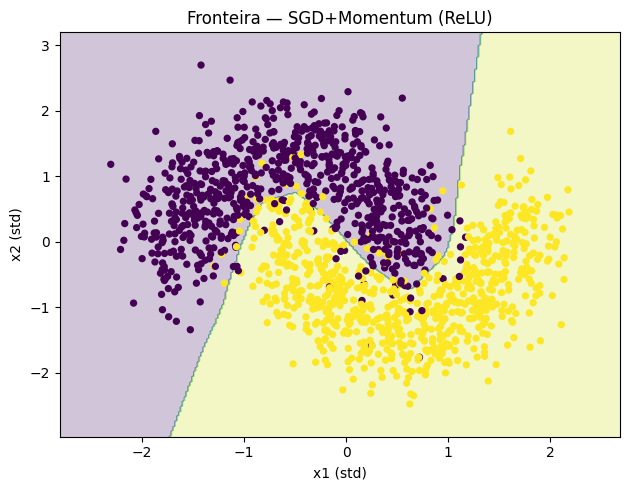

In [9]:

plot_boundary(adam, X_tr_s, y_tr, title="Fronteira — Adam (ReLU)")
plot_boundary(sgd,  X_tr_s, y_tr, title="Fronteira — SGD+Momentum (ReLU)")



## 5) Observações práticas (para seu Notion)
- **ReLU** converge rápido e costuma performar melhor em MLP/CNN; **LeakyReLU** ajuda a evitar neurônios mortos.  
- **Tanh/Sigmoid** saturam; hoje são mais comuns em **modelos sequenciais** (RNN/LSTM).  
- **Adam** geralmente dá bom resultado de cara; **SGD+Momentum** pode alcançar ou superar Adam com **LR e scheduler bem ajustados**.  
- **Schedulers** (ex.: StepLR) ajudam o SGD a estabilizar e podem também polir o Adam no fim do treino.  
- MÉTRICA CHAVE: compare **acc_treino vs acc_teste** (gap) e **loss de validação** (estabilidade).
